In [ ]:
!git clone https://github.com/IntelLabs/bayesian-torch
!pip install bayesian-torch/.
!pip install torch_cka
!sudo apt-get install libmagickwand-dev
!pip install wand

# Test installation
!python -mwand.version

Cloning into 'bayesian-torch'...
remote: Enumerating objects: 714, done.
remote: Counting objects: 100% (449/449), done.
remote: Compressing objects: 100% (215/215), done.
remote: Total 714 (delta 292), reused 362 (delta 234), pack-reused 265
Receiving objects: 100% (714/714), 273.92 KiB | 8.56 MiB/s, done.
Resolving deltas: 100% (449/449), done.
Processing ./bayesian-torch
  Preparing metadata (setup.py) ... done
  Created wheel for bayesian-torch: filename=bayesian_torch-0.4.0-py3-none-any.whl size=77122 sha256=37db6484038cb07642a93dfcdde742d59f3cb578ecaa5434f3fc1f9b4492c4c7
  Stored in directory: /root/.cache/pip/wheels/c4/64/36/327a5aa82508f440c69defc36b554b49f41c2b5780c95fb461
Successfully built bayesian-torch
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-freedesktop gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss


import os
import PIL
import time
import math
import random
import os.path
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch_cka import CKA
import matplotlib.pyplot as plt
import torch.utils.data as data


# /////////////// Distortion Helpers ///////////////
import wand
import warnings
import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates


warnings.simplefilter("ignore", UserWarning)


torch.manual_seed(38)


<ipython-input-2-6310ae5653f5>:39: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [18]:
# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

max_lr = 0.01
num_epochs = 100
batch_size = 95
learning_rate = 0.001

# n_alpha = 5
# n_beta = 3
# p_alpha = [1/n_alpha for _ in range(n_alpha)]
# p_c_beta_alpha = [1/n_beta for _ in range(n_beta)]


In [19]:
train_aug_transform = transforms.Compose([
  transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
  transforms.ToTensor()])

train_transform = transforms.Compose([
  transforms.ToTensor()])

test_aug_transform = transforms.Compose([
  transforms.AutoAugment(AutoAugmentPolicy.CIFAR10),
  transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.ToTensor()])


train_dataset           = torchvision.datasets.CIFAR10(root='./data/' ,train=True,  transform=train_transform,  download=True)
train_aug_dataset       = torchvision.datasets.CIFAR10(root='./data/' ,train=True,  transform=train_aug_transform,  download=True)
test_dataset            = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_transform)
test_aug_dataset        = torchvision.datasets.CIFAR10(root='./data/' ,train=False, transform=test_aug_transform)

train_loader           = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)
train_aug_loader       = torch.utils.data.DataLoader(dataset=train_aug_dataset , batch_size=batch_size, pin_memory=True, shuffle=True  , drop_last=True)
test_loader            = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )
test_aug_loader        = torch.utils.data.DataLoader(dataset=test_aug_dataset,  batch_size=batch_size, pin_memory=True, shuffle=False, drop_last=True )


Files already downloaded and verified
Files already downloaded and verified


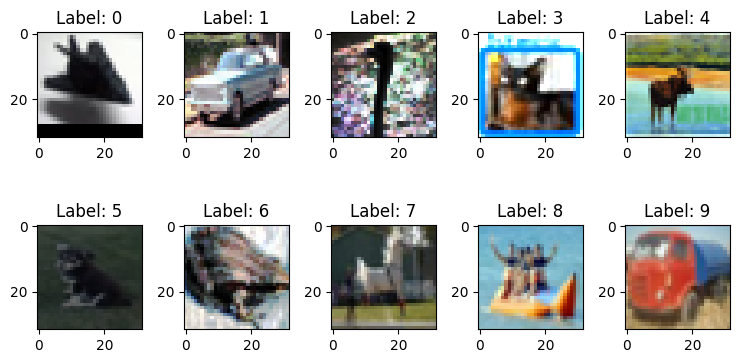

In [ ]:
def plot_set_images(n_row, n_col, images, labels, label_text="Label: "):
  num=len(images)
  num_row=n_row
  num_col=n_col
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
      ax.set_title('{}{}'.format(label_text, labels[i]))
  plt.tight_layout()
  plt.show()

# labels =
images_set = []
labels_set = []
j=0
for i in range(10):
  while i != train_aug_dataset[j][1]:
    j += 1
  images_set.append(train_aug_dataset[j][0])
  labels_set.append(train_aug_dataset[j][1])


plot_set_images(2, 5, images_set, labels_set, "Label: ")

In [ ]:
def disk(radius, alias_blur=0.1, dtype=np.float32):
    if radius <= 8:
        L = np.arange(-8, 8 + 1)
        ksize = (3, 3)
    else:
        L = np.arange(-radius, radius + 1)
        ksize = (5, 5)
    X, Y = np.meshgrid(L, L)
    aliased_disk = np.array((X ** 2 + Y ** 2) <= radius ** 2, dtype=dtype)
    aliased_disk /= np.sum(aliased_disk)

    # supersample disk to antialias
    return cv2.GaussianBlur(aliased_disk, ksize=ksize, sigmaX=alias_blur)


# Tell Python about the C method
wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle


# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)


# modification of https://github.com/FLHerne/mapgen/blob/master/diamondsquare.py
def plasma_fractal(mapsize=32, wibbledecay=3):
    """
    Generate a heightmap using diamond-square algorithm.
    Return square 2d array, side length 'mapsize', of floats in range 0-255.
    'mapsize' must be a power of two.
    """
    assert (mapsize & (mapsize - 1) == 0)
    maparray = np.empty((mapsize, mapsize), dtype=np.float_)
    maparray[0, 0] = 0
    stepsize = mapsize
    wibble = 100

    def wibbledmean(array):
        return array / 4 + wibble * np.random.uniform(-wibble, wibble, array.shape)

    def fillsquares():
        """For each square of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        cornerref = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        squareaccum = cornerref + np.roll(cornerref, shift=-1, axis=0)
        squareaccum += np.roll(squareaccum, shift=-1, axis=1)
        maparray[stepsize // 2:mapsize:stepsize,
        stepsize // 2:mapsize:stepsize] = wibbledmean(squareaccum)

    def filldiamonds():
        """For each diamond of points stepsize apart,
           calculate middle value as mean of points + wibble"""
        mapsize = maparray.shape[0]
        drgrid = maparray[stepsize // 2:mapsize:stepsize, stepsize // 2:mapsize:stepsize]
        ulgrid = maparray[0:mapsize:stepsize, 0:mapsize:stepsize]
        ldrsum = drgrid + np.roll(drgrid, 1, axis=0)
        lulsum = ulgrid + np.roll(ulgrid, -1, axis=1)
        ltsum = ldrsum + lulsum
        maparray[0:mapsize:stepsize, stepsize // 2:mapsize:stepsize] = wibbledmean(ltsum)
        tdrsum = drgrid + np.roll(drgrid, 1, axis=1)
        tulsum = ulgrid + np.roll(ulgrid, -1, axis=0)
        ttsum = tdrsum + tulsum
        maparray[stepsize // 2:mapsize:stepsize, 0:mapsize:stepsize] = wibbledmean(ttsum)

    while stepsize >= 2:
        fillsquares()
        filldiamonds()
        stepsize //= 2
        wibble /= wibbledecay

    maparray -= maparray.min()
    return maparray / maparray.max()


def clipped_zoom(img, zoom_factor):
    h = img.shape[0]
    # ceil crop height(= crop width)
    ch = int(np.ceil(h / zoom_factor))

    top = (h - ch) // 2
    img = scizoom(img[top:top + ch, top:top + ch], (zoom_factor, zoom_factor, 1), order=1)
    # trim off any extra pixels
    trim_top = (img.shape[0] - h) // 2

    return img[trim_top:trim_top + h, trim_top:trim_top + h]


# /////////////// End Distortion Helpers ///////////////


# /////////////// Distortions ///////////////

def gaussian_noise(x, severity=1):
    c = [0.04, 0.06, .08, .09, .10][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def shot_noise(x, severity=1):
    c = [500, 250, 100, 75, 50][severity - 1]

    x = np.array(x) / 255.
    return np.clip(np.random.poisson(x * c) / c, 0, 1) * 255


def impulse_noise(x, severity=1):
    c = [.01, .02, .03, .05, .07][severity - 1]

    x = sk.util.random_noise(np.array(x) / 255., mode='s&p', amount=c)
    return np.clip(x, 0, 1) * 255


def speckle_noise(x, severity=1):
    c = [.06, .1, .12, .16, .2][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + x * np.random.normal(size=x.shape, scale=c), 0, 1) * 255


def gaussian_blur(x, severity=1):
    c = [.4, .6, 0.7, .8, 1][severity - 1]

    x = gaussian(np.array(x) / 255., sigma=c, multichannel=True)
    return np.clip(x, 0, 1) * 255


def glass_blur(x, severity=1):
    # sigma, max_delta, iterations
    c = [(0.05,1,1), (0.25,1,1), (0.4,1,1), (0.25,1,2), (0.4,1,2)][severity - 1]

    x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)

    # locally shuffle pixels
    for i in range(c[2]):
        for h in range(32 - c[1], c[1], -1):
            for w in range(32 - c[1], c[1], -1):
                dx, dy = np.random.randint(-c[1], c[1], size=(2,))
                h_prime, w_prime = h + dy, w + dx
                # swap
                x[h, w], x[h_prime, w_prime] = x[h_prime, w_prime], x[h, w]

    return np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0, 1) * 255


def defocus_blur(x, severity=1):
    c = [(0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (1, 0.2), (1.5, 0.1)][severity - 1]

    x = np.array(x) / 255.
    kernel = disk(radius=c[0], alias_blur=c[1])

    channels = []
    for d in range(3):
        channels.append(cv2.filter2D(x[:, :, d], -1, kernel))
    channels = np.array(channels).transpose((1, 2, 0))  # 3x32x32 -> 32x32x3

    return np.clip(channels, 0, 1) * 255


def motion_blur(x, severity=1):
    c = [(6,1), (6,1.5), (6,2), (8,2), (9,2.5)][severity - 1]

    output = BytesIO()
    x.save(output, format='PNG')
    x = MotionImage(blob=output.getvalue())

    x.motion_blur(radius=c[0], sigma=c[1], angle=np.random.uniform(-45, 45))

    x = cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
                     cv2.IMREAD_UNCHANGED)

    if x.shape != (32, 32):
        return np.clip(x[..., [2, 1, 0]], 0, 255)  # BGR to RGB
    else:  # greyscale to RGB
        return np.clip(np.array([x, x, x]).transpose((1, 2, 0)), 0, 255)


def zoom_blur(x, severity=1):
    c = [np.arange(1, 1.06, 0.01), np.arange(1, 1.11, 0.01), np.arange(1, 1.16, 0.01),
         np.arange(1, 1.21, 0.01), np.arange(1, 1.26, 0.01)][severity - 1]

    x = (np.array(x) / 255.).astype(np.float32)
    out = np.zeros_like(x)
    for zoom_factor in c:
        out += clipped_zoom(x, zoom_factor)

    x = (x + out) / (len(c) + 1)
    return np.clip(x, 0, 1) * 255


def fog(x, severity=1):
    c = [(.2,3), (.5,3), (0.75,2.5), (1,2), (1.5,1.75)][severity - 1]

    x = np.array(x) / 255.
    max_val = x.max()
    x += c[0] * plasma_fractal(wibbledecay=c[1])[:32, :32][..., np.newaxis]
    return np.clip(x * max_val / (max_val + c[0]), 0, 1) * 255


def frost(x, severity=1):
    c = [(1, 0.2), (1, 0.3), (0.9, 0.4), (0.85, 0.4), (0.75, 0.45)][severity - 1]
    idx = np.random.randint(5)
    filename = ['./frost1.png', './frost2.png', './frost3.png', './frost4.jpg', './frost5.jpg', './frost6.jpg'][idx]
    frost = cv2.imread(filename)
    frost = cv2.resize(frost, (0, 0), fx=0.2, fy=0.2)
    # randomly crop and convert to rgb
    x_start, y_start = np.random.randint(0, frost.shape[0] - 32), np.random.randint(0, frost.shape[1] - 32)
    frost = frost[x_start:x_start + 32, y_start:y_start + 32][..., [2, 1, 0]]

    return np.clip(c[0] * np.array(x) + c[1] * frost, 0, 255)


def snow(x, severity=1):
    c = [(0.1,0.2,1,0.6,8,3,0.95),
         (0.1,0.2,1,0.5,10,4,0.9),
         (0.15,0.3,1.75,0.55,10,4,0.9),
         (0.25,0.3,2.25,0.6,12,6,0.85),
         (0.3,0.3,1.25,0.65,14,12,0.8)][severity - 1]

    x = np.array(x, dtype=np.float32) / 255.
    snow_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])  # [:2] for monochrome

    snow_layer = clipped_zoom(snow_layer[..., np.newaxis], c[2])
    snow_layer[snow_layer < c[3]] = 0

    snow_layer = PILImage.fromarray((np.clip(snow_layer.squeeze(), 0, 1) * 255).astype(np.uint8), mode='L')
    output = BytesIO()
    snow_layer.save(output, format='PNG')
    snow_layer = MotionImage(blob=output.getvalue())

    snow_layer.motion_blur(radius=c[4], sigma=c[5], angle=np.random.uniform(-135, -45))

    snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8),
                              cv2.IMREAD_UNCHANGED) / 255.
    snow_layer = snow_layer[..., np.newaxis]

    x = c[6] * x + (1 - c[6]) * np.maximum(x, cv2.cvtColor(x, cv2.COLOR_RGB2GRAY).reshape(32, 32, 1) * 1.5 + 0.5)
    return np.clip(x + snow_layer + np.rot90(snow_layer, k=2), 0, 1) * 255


def spatter(x, severity=1):
    c = [(0.62,0.1,0.7,0.7,0.5,0),
         (0.65,0.1,0.8,0.7,0.5,0),
         (0.65,0.3,1,0.69,0.5,0),
         (0.65,0.1,0.7,0.69,0.6,1),
         (0.65,0.1,0.5,0.68,0.6,1)][severity - 1]
    x = np.array(x, dtype=np.float32) / 255.

    liquid_layer = np.random.normal(size=x.shape[:2], loc=c[0], scale=c[1])

    liquid_layer = gaussian(liquid_layer, sigma=c[2])
    liquid_layer[liquid_layer < c[3]] = 0
    if c[5] == 0:
        liquid_layer = (liquid_layer * 255).astype(np.uint8)
        dist = 255 - cv2.Canny(liquid_layer, 50, 150)
        dist = cv2.distanceTransform(dist, cv2.DIST_L2, 5)
        _, dist = cv2.threshold(dist, 20, 20, cv2.THRESH_TRUNC)
        dist = cv2.blur(dist, (3, 3)).astype(np.uint8)
        dist = cv2.equalizeHist(dist)
        #     ker = np.array([[-1,-2,-3],[-2,0,0],[-3,0,1]], dtype=np.float32)
        #     ker -= np.mean(ker)
        ker = np.array([[-2, -1, 0], [-1, 1, 1], [0, 1, 2]])
        dist = cv2.filter2D(dist, cv2.CV_8U, ker)
        dist = cv2.blur(dist, (3, 3)).astype(np.float32)

        m = cv2.cvtColor(liquid_layer * dist, cv2.COLOR_GRAY2BGRA)
        m /= np.max(m, axis=(0, 1))
        m *= c[4]

        # water is pale turqouise
        color = np.concatenate((175 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1]),
                                238 / 255. * np.ones_like(m[..., :1])), axis=2)

        color = cv2.cvtColor(color, cv2.COLOR_BGR2BGRA)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2BGRA)

        return cv2.cvtColor(np.clip(x + m * color, 0, 1), cv2.COLOR_BGRA2BGR) * 255
    else:
        m = np.where(liquid_layer > c[3], 1, 0)
        m = gaussian(m.astype(np.float32), sigma=c[4])
        m[m < 0.8] = 0
        #         m = np.abs(m) ** (1/c[4])

        # mud brown
        color = np.concatenate((63 / 255. * np.ones_like(x[..., :1]),
                                42 / 255. * np.ones_like(x[..., :1]),
                                20 / 255. * np.ones_like(x[..., :1])), axis=2)

        color *= m[..., np.newaxis]
        x *= (1 - m[..., np.newaxis])

        return np.clip(x + color, 0, 1) * 255


def contrast(x, severity=1):
    c = [.75, .5, .4, .3, 0.15][severity - 1]

    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255


def brightness(x, severity=1):
    c = [.05, .1, .15, .2, .3][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 2] = np.clip(x[:, :, 2] + c, 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def saturate(x, severity=1):
    c = [(0.3, 0), (0.1, 0), (1.5, 0), (2, 0.1), (2.5, 0.2)][severity - 1]

    x = np.array(x) / 255.
    x = sk.color.rgb2hsv(x)
    x[:, :, 1] = np.clip(x[:, :, 1] * c[0] + c[1], 0, 1)
    x = sk.color.hsv2rgb(x)

    return np.clip(x, 0, 1) * 255


def jpeg_compression(x, severity=1):
    c = [80, 65, 58, 50, 40][severity - 1]

    output = BytesIO()
    x.save(output, 'JPEG', quality=c)
    x = PILImage.open(output)

    return x


def pixelate(x, severity=1):
    c = [0.95, 0.9, 0.85, 0.75, 0.65][severity - 1]

    x = x.resize((int(32 * c), int(32 * c)), PILImage.BOX)
    x = x.resize((32, 32), PILImage.BOX)

    return x


# mod of https://gist.github.com/erniejunior/601cdf56d2b424757de5
def elastic_transform(image, severity=1):
    IMSIZE = 32
    c = [(IMSIZE*0, IMSIZE*0, IMSIZE*0.08),
         (IMSIZE*0.05, IMSIZE*0.2, IMSIZE*0.07),
         (IMSIZE*0.08, IMSIZE*0.06, IMSIZE*0.06),
         (IMSIZE*0.1, IMSIZE*0.04, IMSIZE*0.05),
         (IMSIZE*0.1, IMSIZE*0.03, IMSIZE*0.03)][severity - 1]

    image = np.array(image, dtype=np.float32) / 255.
    shape = image.shape
    shape_size = shape[:2]

    # random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size,
                       [center_square[0] + square_size, center_square[1] - square_size],
                       center_square - square_size])
    pts2 = pts1 + np.random.uniform(-c[2], c[2], size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dy = (gaussian(np.random.uniform(-1, 1, size=shape[:2]),
                   c[1], mode='reflect', truncate=3) * c[0]).astype(np.float32)
    dx, dy = dx[..., np.newaxis], dy[..., np.newaxis]

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1)), np.reshape(z, (-1, 1))
    return np.clip(map_coordinates(image, indices, order=1, mode='reflect').reshape(shape), 0, 1) * 255


# /////////////// End Distortions ///////////////

import collections

print('Using CIFAR-10 data')

d = collections.OrderedDict()
d['Gaussian Noise'] = gaussian_noise
d['Shot Noise'] = shot_noise
d['Impulse Noise'] = impulse_noise
d['Defocus Blur'] = defocus_blur
d['Glass Blur'] = glass_blur
d['Motion Blur'] = motion_blur
d['Zoom Blur'] = zoom_blur
d['Snow'] = snow
d['Frost'] = frost
d['Fog'] = fog
d['Brightness'] = brightness
d['Contrast'] = contrast
d['Elastic'] = elastic_transform
d['Pixelate'] = pixelate
d['JPEG'] = jpeg_compression

d['Speckle Noise'] = speckle_noise
d['Gaussian Blur'] = gaussian_blur
d['Spatter'] = spatter
d['Saturate'] = saturate


# test_data = datasets.CIFAR10(root='./data/' ,train=True,  download=True)
# convert_img = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage()])


# for method_name in d.keys():
#     print('Creating images for the corruption', method_name)
#     cifar_c, labels = [], []

#     for severity in range(1,6):
#         corruption = lambda clean_img: d[method_name](clean_img, severity)
#         if severity==5:
#           for img, label in zip(test_data.data, test_data.targets):
#               labels.append(label)
#               print(label)
#               tmp = np.uint8(corruption(convert_img(img)))
#               cifar_c.append(tmp)
#               print(tmp)
#               imgplot = plt.imshow(tmp)
#               break




    # np.save('/share/data/vision-greg2/users/dan/datasets/CIFAR-10-C/' + d[method_name].__name__ + '.npy',
    #         np.array(cifar_c).astype(np.uint8))

    # np.save('/share/data/vision-greg2/users/dan/datasets/CIFAR-10-C/labels.npy',
    #         np.array(labels).astype(np.uint8))

Using CIFAR-10 data


In [ ]:
const_bnn_prior_parameters = {
        "prior_mu": 0.0,
        "prior_sigma": 1.0,
        "posterior_mu_init": 0.0,
        "posterior_rho_init": -3.0,
        "type": "Reparameterization",  # Flipout or Reparameterization
        "moped_enable": False,  # True to initialize mu/sigma from the pretrained dnn weights
        "moped_delta": 0.5,
}

# model = torchvision.models.resnet18(pretrained=True)
# dnn_to_bnn(model, const_bnn_prior_parameters)

In [ ]:
train_data = datasets.CIFAR10(root='./data/' ,train=True,  download=True)
test_data = datasets.CIFAR10(root='./data/' ,train=False)

len_dataset = len(test_data)
print(len_dataset)
convert_img = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage()])

Files already downloaded and verified
10000


In [27]:
def test(model, test_type='st'):
  model = model.to(device)
  model.eval()
  total_acc_test=0

  if test_type=='st':
    for img, label in zip(test_data.data, test_data.targets):
          img = torch.FloatTensor(img.transpose((2, 0, 1)).reshape(1, 3, 32, 32)).to(device)
          label = torch.tensor(np.array([label])).to(device)
          Z =  model(img).to(device)
          total_acc_test += (Z.max(dim=1)[1] == label).sum().item()
          # break
    print('Acc_Test =', total_acc_test /len_dataset  ,sep="\t")
    return total_acc_test / len(test_loader.dataset)




  elif test_type=='at':
    for img, label in zip(test_data.data, test_data.targets):
          image = convert_img(img)
          images = []
          for method_name in d.keys():
                # print('Creating images for the corruption', method_name)
                for severity in range(1,6):
                    corruption = lambda clean_img: d[method_name](clean_img, severity)
                    tmp = np.uint8(corruption(image))
                    images.append(tmp.transpose((2, 0, 1)))

          images = torch.FloatTensor(np.array(images)).to(device)
          labels = torch.tensor(np.array([label])).to(device)

          Z =  model(images).to(device)
          Z = torch.tensor([torch.mode(Z.max(dim=1)[1], 0)[0]]).to(device)
          total_acc_test += (Z == labels).sum().item()
          # break
    print('Acc_Test =', total_acc_test / len_dataset ,sep="\t")
    return total_acc_test / len(test_loader.dataset)

# model = torchvision.models.resnet18(pretrained=False).to(device)
# model.fc = nn.Sequential(
#     nn.Dropout(0.2),
#     nn.Linear(model.fc.in_features, 10)
# )
# dnn_to_bnn(model, const_bnn_prior_parameters)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))
# acc = test(model, test_type='st')
# acc = test(model, test_type='at')

In [33]:
def train(model, criterion, optimizer, sched, train_loader = train_loader, T1=1, T2=1, training_type='st'):
  model.train()
  if training_type == 'st':
    for epoch in range(num_epochs):
        losses=[]
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs =  model(images).to(device)
            loss1 = criterion(outputs, labels)
            kl = get_kl_loss(model).to(device)

            loss = ((loss1**(1.0/T1)) + ((kl / batch_size)**T2)).to(device)

            losses.append(loss.item())


            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()


            optimizer.step()
            sched.step()
            # break


        if epoch%2==0:
          print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          test(model, test_type='st')
          test(model, test_type='at')
          model.train()
          print()
          print()




  elif training_type == 'at':
    for epoch in range(num_epochs):
      losses = []
      for img, label in zip(train_data.data, train_data.targets):
          img = convert_img(img)
          images, labels = [], []
          for method_name in d.keys():
              # print('Creating images for the corruption', method_name)
              for severity in range(1,6):
                  corruption = lambda clean_img: d[method_name](clean_img, severity)
                  labels.append(label)
                  tmp = np.uint8(corruption(img))
                  images.append(tmp.transpose((2, 0, 1)))


          images = torch.FloatTensor(np.array(images)).to(device)
          labels = torch.tensor(labels).to(device)

          outputs =  model(images).to(device)

          loss = criterion(outputs, labels)

          kl = get_kl_loss(model).to(device)


          loss = ((loss**(1.0/T1)) + ((kl /(5*len(d.keys())))**T2)).to(device)

          losses.append(loss.item())


          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()

          optimizer.step()
          sched.step()
          # break


      if epoch%2==0:
          print('epoch : ' + str(epoch) +' -->  loss_Train = ' + str(np.array(losses).mean()))
          test(model, test_type='st')
          test(model, test_type='at')
          model.train()
          print()
          print()




  return model, losses

In [34]:
models = []
losses = []
model_type = ['st', 'at' ]

for mt in model_type:
  if mt=='st':
    print()
    print()
    print("Training a BNN by clean data and standard scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.fc.in_features, 10)
    )
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_data))
    trained_model, loss = train(model.to(device),  criterion, optimizer, sched, train_loader, T1=1, T2=1, training_type='st')
    models.append(trained_model)

    print("###########################################################################################")


  if mt=='at':
    print()
    print()
    print("Training a BNN by augmented data and RNVI scheme: ")
    model = torchvision.models.resnet18(pretrained=False).to(device)
    model.fc = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(model.fc.in_features, 10)
    )
    dnn_to_bnn(model, const_bnn_prior_parameters)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, steps_per_epoch=len(train_data))
    trained_model, loss = train(model.to(device),  criterion, optimizer, sched, train_loader, T1=1, T2=1, training_type='at')
    models.append(trained_model)

    print("###########################################################################################")




Training a BNN by clean data and standard scheme: 
epoch : 0 -->  loss_Train = 6.807145118713379
Acc_Test =	0.0


<ipython-input-6-edc4842e1358>:136: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x = np.uint8(gaussian(np.array(x) / 255., sigma=c[0], multichannel=True) * 255)
<ipython-input-6-edc4842e1358>:147: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return np.clip(gaussian(x / 255., sigma=c[0], multichannel=True), 0, 1) * 255
<ipython-input-6-edc4842e1358>:173: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
<ipython-input-6-edc4842e1358>:237: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  snow_layer = cv2.imdecode(np.fromstring(snow_layer.make_blob(), np.uint8)

Acc_Test =	0.0


epoch : 2 -->  loss_Train = 5.941267967224121
Acc_Test =	0.0001
Acc_Test =	0.0


epoch : 4 -->  loss_Train = 6.17362117767334
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 6 -->  loss_Train = 5.875408172607422
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 8 -->  loss_Train = 5.45933198928833
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 10 -->  loss_Train = 6.466979503631592
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 12 -->  loss_Train = 5.717804431915283
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 14 -->  loss_Train = 6.182376384735107
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 16 -->  loss_Train = 6.900547981262207
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 18 -->  loss_Train = 6.18644380569458
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 20 -->  loss_Train = 5.9816060066223145
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 22 -->  loss_Train = 5.206014633178711
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 24 -->  loss_Train = 5.441688537597656
Acc_Test =	0.0
Acc_Test =	0.0


epoch : 26 -->  loss_Train = 5.9654297